## Filtering an ARMA process

In [1]:
import jax
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
sns.set_palette("colorblind")

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import ssm

## Defining the ARMA process

In [6]:
key = jax.random.PRNGKey(3141)

In [19]:
ma_n = 10
H_ma = jnp.ones(ma_n) * 1.0
H_ar = jnp.ones(1) * 0.99
H, F, T = ssm.init_arma_components(H_ma=H_ma)
# H, F, T = ssm.init_arma_components(H_ar=H_ar)
dim_state = len(H)
R = jnp.eye(1) * 2.0 ** 2

In [20]:
n_steps = 50
n_test = 20
steps = jnp.arange(n_steps)
sample = ssm.sample_ssm(key, F, H, T, R, n_steps + n_test)

test = jax.tree.map(lambda x: x[-n_test:], sample)
sample = jax.tree.map(lambda x: x[:-n_test], sample)

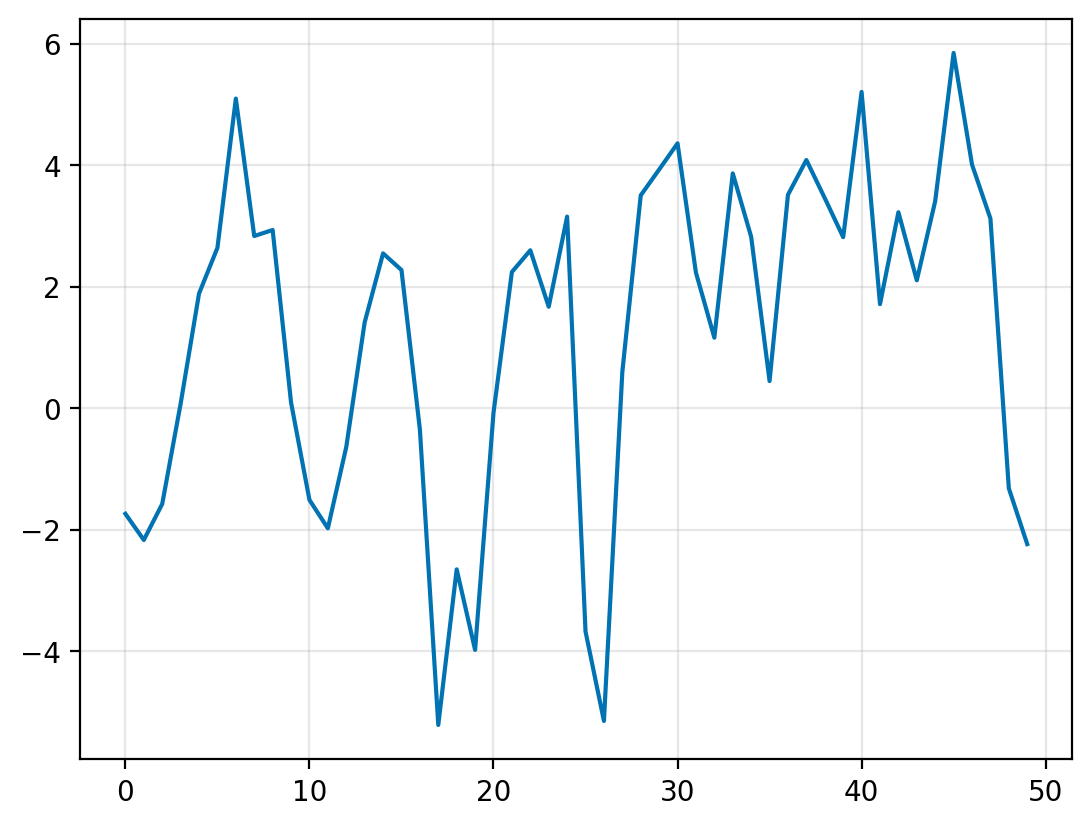

In [21]:
plt.plot(sample["y"])
plt.grid(alpha=0.3)

## The Kalman filter (with constant dynamics)

In [22]:
def kf_step(bel, y, H, F, R, Q):
    mu, Sigma = bel

    # Predict
    mu_pred = F @ mu
    Sigma_pred = F @ Sigma @ F.T + Q

    # innovation
    S = H @ Sigma_pred @ H.T + R
    K = jnp.linalg.solve(S, H @ Sigma_pred).T
    err =  y - H @ mu_pred # innovation

    # Update
    mu = mu_pred + K @ err
    Sigma = Sigma_pred - K @ S @ K.T
    bel_next = (mu, Sigma)

    out = {
        "mu": mu,
        "err": err,
        "yhat": H @ mu_pred
    }

    return bel_next, out

In [23]:
Q = T @ R @ T.T
_step = partial(kf_step, H=H[None, :], F=F, R=R, Q=Q)
y = sample["y"]

mu_init = jnp.zeros(dim_state)
Sigma_init = jnp.eye(dim_state)
bel_init = (mu_init, Sigma_init)

(mu, Sigma), hist = jax.lax.scan(_step, bel_init, y[:, None])

In [24]:
filter_hist = jnp.einsum("i,ti->t", H, hist["mu"])

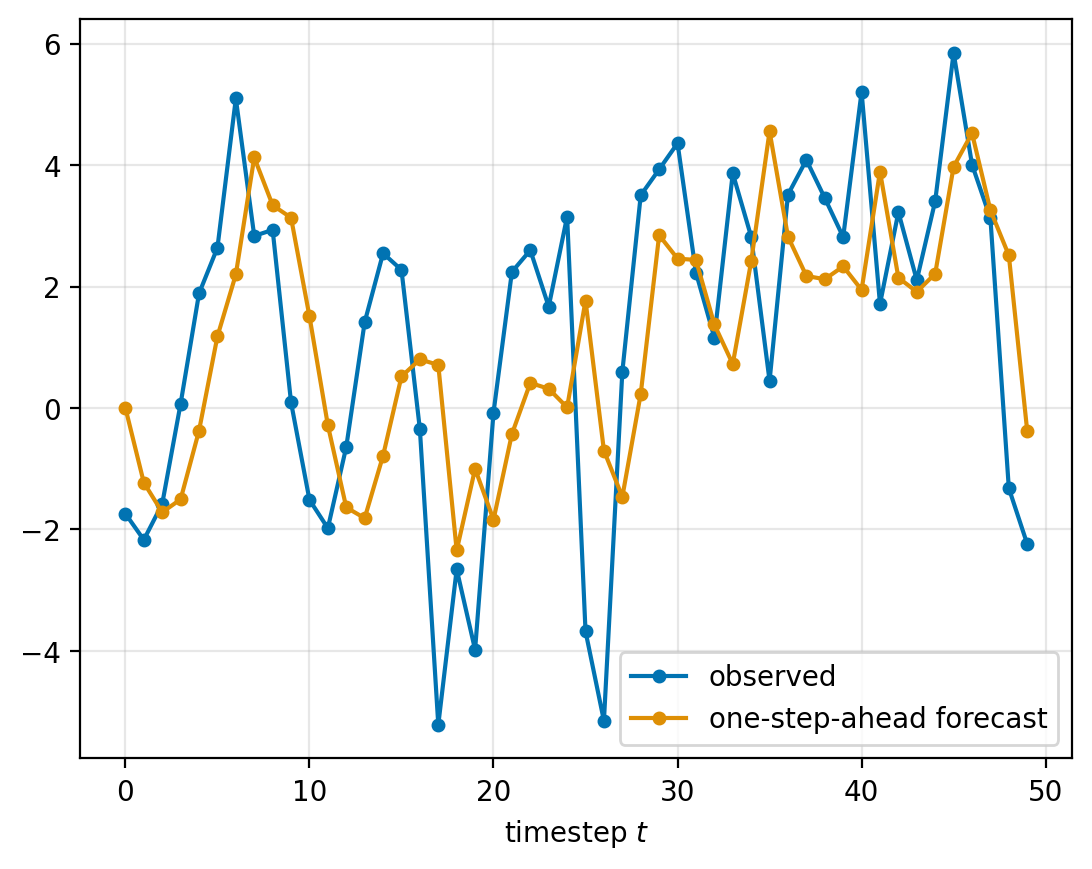

In [25]:
plt.plot(sample["y"], marker="o", markersize=4, label="observed")
plt.plot(hist["yhat"], marker="o", markersize=4, label="one-step-ahead forecast")
plt.legend()
plt.xlabel("timestep $t$")
plt.grid(alpha=0.3)

## Predictions

In [26]:
@partial(jax.jit, static_argnames=("k",))
def forecast_mean(F, mu, k):
    """
    Following Proposition 2.2 in F.02
    """
    def _step(mu, _):
        mu_next = F @ mu
        return mu_next, mu_next
    steps = jnp.arange(k)
    _, mu_pred = jax.lax.scan(_step, mu, steps)
    return mu_pred


@partial(jax.jit, static_argnames=("k",))
def forecast_cov(F, Sigma, Q, k):
    """
    Following Proposition 2.3 in F.02
    """
    def _step(state, _):
        Sigma_mult, dynamics_carry, F_mult = state

        dynamics_carry = dynamics_carry + F_mult @ Q @ F_mult.T
        F_mult = F @ F_mult        
        Sigma_mult = F @ Sigma_mult @ F.T

        Sigma_pred = Sigma_mult + dynamics_carry
        
        state_next = (Sigma_mult, dynamics_carry, F_mult)
        return state_next, Sigma_pred
    steps = jnp.arange(k)
    dim_state = len(Q)
    state_init = (Sigma, jnp.zeros((dim_state, dim_state)), F)
    _, Sigma_pred = jax.lax.scan(_step, state_init, steps)
    return Sigma_pred

In [27]:
mu_pred = forecast_mean(F, mu, n_test)
y_pred = jnp.einsum("d,td->t", H, mu_pred)

In [28]:
Sigma_pred = forecast_cov(F, Sigma, Q, n_test)

In [29]:
std_pred = jnp.sqrt(jnp.einsum("sij,i,j->s", Sigma_pred, H, H))

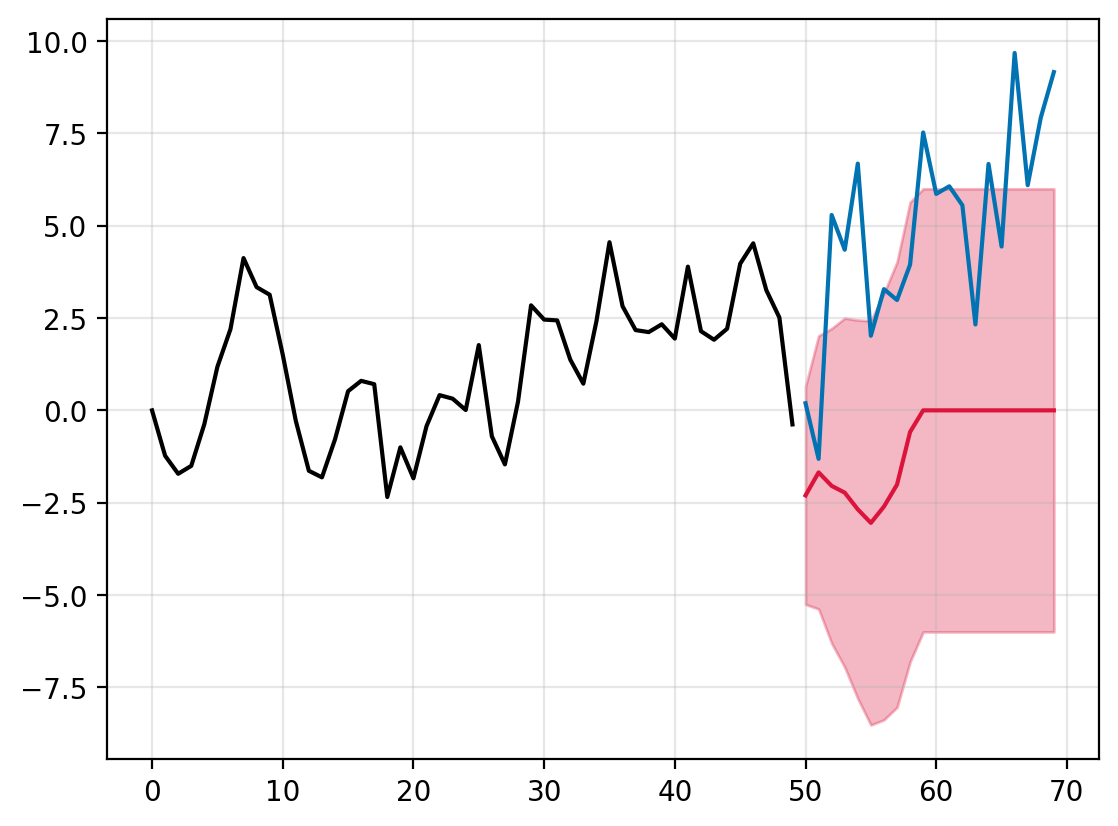

In [30]:
steps_pred = jnp.arange(n_test) + n_steps
plt.plot(steps, hist["yhat"], c="black")
plt.plot(steps_pred, y_pred, c="crimson")
plt.plot(steps_pred, test["y"])
plt.fill_between(steps_pred, y_pred - std_pred, y_pred + std_pred, color="crimson", alpha=0.3)
plt.grid(alpha=0.3)

## What went wrong?